# Initial Trajectory 
Initial state for trajectory optimization should be feasible in order to reduce necessary solver steps.

In [1]:
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
plt.ioff()
from IPython.display import HTML

In [2]:
import torch

from mantrap.agents import DoubleIntegratorDTAgent

position = torch.zeros(2)
velocity = torch.tensor([1, 2]).float()
goal = torch.tensor([10, 0]).float()
dt = 0.4
planning_horizon = 10

agent = DoubleIntegratorDTAgent(position=position, velocity=velocity)
_, control_limit = agent.control_limits()

The initial trajectory should somehow guide the optimization to trajectory, which leads the ego to the goal. Simply create trajectory primitives from the agent current position to its goal within the planning horizon however is not feasible, since it completly ignores the agent's control limits. Also it ignores the agent's dynamics and current state (other than position), so that the actual trajectory is not really useful, which makes optimization harder.

In [3]:
%%time
from mantrap.utility.maths import straight_line

path_direct = straight_line(start=agent.position, end=goal, steps=planning_horizon + 1)
trajectory_direct = agent.expand_trajectory(path=path_direct, dt=dt)
controls_direct = agent.roll_trajectory(trajectory=trajectory_direct, dt=dt)    

torch.gt(torch.norm(controls_direct, dim=1), control_limit)

CPU times: user 7.04 ms, sys: 2.69 ms, total: 9.73 ms
Wall time: 2.28 ms


tensor([False, False, False, False, False, False, False, False, False,  True])

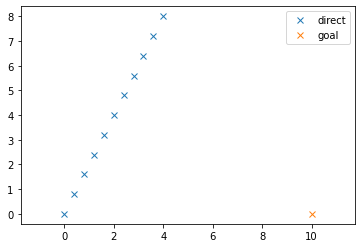

In [4]:
trajectory_direct_np = agent.unroll_trajectory(controls_direct, dt=dt).detach().numpy()

plt.plot(trajectory_direct_np[:, 0], trajectory_direct_np[:, 1], 'x', label="direct")
plt.plot(goal[0], goal[1], 'x', label="goal")
plt.axis("equal")
plt.legend()
plt.show()

# Cubic Splines
Test spline implementation from well known pyrobotics repository (https://github.com/AtsushiSakai/PythonRobotics) to scipy implementation. They result in being exactly the same, for the matter of ease and reduction of code, that has to be tested mainted, and as it is way faster, the scipy implemetation is used.

In [5]:
ax = [0.0, 2.0, 12.5, 10.0, 17.5, 20.0, 25.0]
ay = [0.0, -3.0, -5.0, 6.5, 3.0, 0.0, 0.0]
goal = [ax[-1], ay[-1]]

In [6]:
"""
Cubic spline planner
Author: Atsushi Sakai(@Atsushi_twi)
"""
import bisect
import math
import numpy as np


class Spline:
    """ Cubic Spline class. """

    def __init__(self, x, y):
        self.b, self.c, self.d, self.w = [], [], [], []

        self.x = x
        self.y = y

        self.nx = len(x)  # dimension of x
        h = np.diff(x)

        # calc coefficient c
        self.a = [iy for iy in y]

        # calc coefficient c
        A = self.__calc_A(h)
        B = self.__calc_B(h)
        self.c = np.linalg.solve(A, B)

        # calc spline coefficient b and d
        for i in range(self.nx - 1):
            self.d.append((self.c[i + 1] - self.c[i]) / (3.0 * h[i]))
            tb = (self.a[i + 1] - self.a[i]) / h[i] - h[i] * \
                (self.c[i + 1] + 2.0 * self.c[i]) / 3.0
            self.b.append(tb)

    def calc(self, t):
        """
        Calc position
        if t is outside of the input x, return None
        """

        if t < self.x[0] or t > self.x[-1]:
            return None

        i = self.__search_index(t)
        dx = t - self.x[i]
        result = self.a[i] + self.b[i] * dx + \
            self.c[i] * dx ** 2.0 + self.d[i] * dx ** 3.0

        return result

    def calcd(self, t):
        """
        Calc first derivative
        if t is outside of the input x, return None
        """
        if t < self.x[0] or t > self.x[-1]:
            return None

        i = self.__search_index(t)
        dx = t - self.x[i]
        result = self.b[i] + 2.0 * self.c[i] * dx + 3.0 * self.d[i] * dx ** 2.0
        return result

    def calcdd(self, t):
        if t < self.x[0] or t > self.x[-1]:
            return None

        i = self.__search_index(t)
        dx = t - self.x[i]
        result = 2.0 * self.c[i] + 6.0 * self.d[i] * dx
        return result

    def __search_index(self, x):
        return bisect.bisect(self.x, x) - 1

    def __calc_A(self, h):
        """Calculate matrix A for spline coefficient c. """
        A = np.zeros((self.nx, self.nx))
        A[0, 0] = 1.0
        for i in range(self.nx - 1):
            if i != (self.nx - 2):
                A[i + 1, i + 1] = 2.0 * (h[i] + h[i + 1])
            A[i + 1, i] = h[i]
            A[i, i + 1] = h[i]

        A[0, 1] = 0.0
        A[self.nx - 1, self.nx - 2] = 0.0
        A[self.nx - 1, self.nx - 1] = 1.0
        return A

    def __calc_B(self, h):
        """Calculate matrix B for spline coefficient c. """
        B = np.zeros(self.nx)
        for i in range(self.nx - 2):
            B[i + 1] = 3.0 * (self.a[i + 2] - self.a[i + 1]) / \
                h[i + 1] - 3.0 * (self.a[i + 1] - self.a[i]) / h[i]
        return B


class Spline2D:
    """ 2D Cubic Spline class. """

    def __init__(self, x, y):
        self.s = self.__calc_s(x, y)
        self.sx = Spline(self.s, x)
        self.sy = Spline(self.s, y)

    def __calc_s(self, x, y):
        dx = np.diff(x)
        dy = np.diff(y)
        self.ds = np.hypot(dx, dy)
        s = [0]
        s.extend(np.cumsum(self.ds))
        return s

    def calc_position(self, s):
        x = self.sx.calc(s)
        y = self.sy.calc(s)

        return x, y

    def calc_curvature(self, s):
        dx = self.sx.calcd(s)
        ddx = self.sx.calcdd(s)
        dy = self.sy.calcd(s)
        ddy = self.sy.calcdd(s)
        k = (ddy * dx - ddx * dy) / ((dx ** 2 + dy ** 2)**(3 / 2))
        return k

    def calc_yaw(self, s):
        dx = self.sx.calcd(s)
        dy = self.sy.calcd(s)
        yaw = math.atan2(dy, dx)
        return yaw


def calc_spline_course(x, y, ds=0.1):
    sp = Spline2D(x, y)
    s = list(np.arange(0, sp.s[-1], ds))

    rx, ry, ryaw, rk = [], [], [], []
    for i_s in s:
        ix, iy = sp.calc_position(i_s)
        rx.append(ix)
        ry.append(iy)
        ryaw.append(sp.calc_yaw(i_s))
        rk.append(sp.calc_curvature(i_s))

    return rx, ry, ryaw, rk, s

cx, cy, cyaw, ck, s = calc_spline_course(ax, ay, ds=0.1)

In [7]:
%%timeit
cx, cy, cyaw, ck, s = calc_spline_course(ax, ay, ds=0.1)

7.62 ms ± 266 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [8]:
from mantrap.utility.maths import spline_interpolation

control_points = torch.stack((torch.tensor(ax), torch.tensor(ay)), dim=1)
cxy_spline = spline_interpolation(control_points, num_samples=400)

In [9]:
%%timeit
cxy_spline = spline_interpolation(control_points, num_samples=400)

226 µs ± 19.2 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


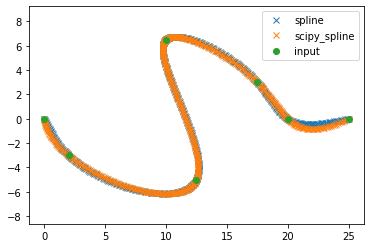

In [10]:
plt.plot(cx, cy, 'x', label="spline")
plt.plot(cxy_spline[:, 0], cxy_spline[:, 1], 'x', label="scipy_spline")
plt.plot(ax,  ay, 'o', label="input")
plt.axis("equal")
plt.legend()
plt.show()

In [12]:
from mantrap.constants import ROBOT_SPEED_MAX, ROBOT_ACC_MAX

MAX_TIME = 100.0  # max simulation time
DT = 0.4  # [s] time tick
DL = 1.0  # [m] course tick.

# Vehicle parameters
LENGTH = 4.5  # [m]
WIDTH = 2.0  # [m]
BACKTOWHEEL = 1.0  # [m]
WHEEL_LEN = 0.3  # [m]
WHEEL_WIDTH = 0.2  # [m]
TREAD = 0.7  # [m]
WB = 2.5  # [m]

MAX_STEER = np.deg2rad(45.0)  # maximum steering angle [rad]
MAX_DSTEER = np.deg2rad(30.0)  # maximum steering speed [rad/s]
MAX_SPEED = ROBOT_SPEED_MAX  # maximum speed [m/s]
MIN_SPEED = - ROBOT_SPEED_MAX  # minimum speed [m/s]
MAX_ACCEL = ROBOT_ACC_MAX  # maximum accel [m/ss]

TARGET_SPEED = 10.0 / 3.6  # [m/s] target speed

# MPC Path Tracking

In [13]:
%%time
"""
Path tracking simulation with iterative linear model predictive control for speed and steer control
author: Atsushi Sakai (@Atsushi_twi)
"""
import matplotlib.pyplot as plt
import cvxpy
import math
import numpy as np


NX = 4  # x = x, y, v, yaw
NU = 2  # a = [accel, steer]
T = 5  # horizon length

# mpc parameters
R = np.diag([0.01, 0.01])  # input cost matrix
Rd = np.diag([0.01, 1.0])  # input difference cost matrix
Q = np.diag([1.0, 1.0, 0.5, 0.5])  # state cost matrix
Qf = Q  # state final matrix
GOAL_DIS = 1.5  # goal distance
STOP_SPEED = 0.5 / 3.6  # stop speed

# iterative paramter
MAX_ITER = 3  # Max iteration
DU_TH = 100.0  # iteration finish param

N_IND_SEARCH = 10  # Search index number


class State:
    """
    vehicle state class
    """

    def __init__(self, x=0.0, y=0.0, yaw=0.0, v=0.0):
        self.x = x
        self.y = y
        self.yaw = yaw
        self.v = v
        self.predelta = None


def pi_2_pi(angle):
    while(angle > math.pi):
        angle = angle - 2.0 * math.pi

    while(angle < -math.pi):
        angle = angle + 2.0 * math.pi

    return angle


def get_linear_model_matrix(v, phi, delta):

    A = np.zeros((NX, NX))
    A[0, 0] = 1.0
    A[1, 1] = 1.0
    A[2, 2] = 1.0
    A[3, 3] = 1.0
    A[0, 2] = DT * math.cos(phi)
    A[0, 3] = - DT * v * math.sin(phi)
    A[1, 2] = DT * math.sin(phi)
    A[1, 3] = DT * v * math.cos(phi)
    A[3, 2] = DT * math.tan(delta) / WB

    B = np.zeros((NX, NU))
    B[2, 0] = DT
    B[3, 1] = DT * v / (WB * math.cos(delta) ** 2)

    C = np.zeros(NX)
    C[0] = DT * v * math.sin(phi) * phi
    C[1] = - DT * v * math.cos(phi) * phi
    C[3] = - DT * v * delta / (WB * math.cos(delta) ** 2)

    return A, B, C


def update_state(state, a, delta):
    state.x = state.x + state.v * math.cos(state.yaw) * DT
    state.y = state.y + state.v * math.sin(state.yaw) * DT
    state.yaw = state.yaw + state.v / WB * math.tan(delta) * DT
    state.v = state.v + a * DT

    if state. v > MAX_SPEED:
        state.v = MAX_SPEED
    elif state. v < MIN_SPEED:
        state.v = MIN_SPEED

    return state


def get_nparray_from_matrix(x):
    return np.array(x).flatten()


def calc_nearest_index(state, cx, cy, cyaw, pind):

    dx = [state.x - icx for icx in cx[pind:(pind + N_IND_SEARCH)]]
    dy = [state.y - icy for icy in cy[pind:(pind + N_IND_SEARCH)]]

    d = [idx ** 2 + idy ** 2 for (idx, idy) in zip(dx, dy)]

    mind = min(d)

    ind = d.index(mind) + pind

    mind = math.sqrt(mind)

    dxl = cx[ind] - state.x
    dyl = cy[ind] - state.y

    angle = pi_2_pi(cyaw[ind] - math.atan2(dyl, dxl))
    if angle < 0:
        mind *= -1

    return ind, mind


def predict_motion(x0, oa, od, xref):
    xbar = xref * 0.0
    for i, _ in enumerate(x0):
        xbar[i, 0] = x0[i]

    state = State(x=x0[0], y=x0[1], yaw=x0[3], v=x0[2])
    for (ai, di, i) in zip(oa, od, range(1, T + 1)):
        state = update_state(state, ai, di)
        xbar[0, i] = state.x
        xbar[1, i] = state.y
        xbar[2, i] = state.v
        xbar[3, i] = state.yaw

    return xbar


def iterative_linear_mpc_control(xref, x0, dref, oa, od):
    """
    MPC contorl with updating operational point iteraitvely
    """

    if oa is None or od is None:
        oa = [0.0] * T
        od = [0.0] * T

    for i in range(MAX_ITER):
        xbar = predict_motion(x0, oa, od, xref)
        poa, pod = oa[:], od[:]
        oa, od, ox, oy, oyaw, ov = linear_mpc_control(xref, xbar, x0, dref)
        du = sum(abs(oa - poa)) + sum(abs(od - pod))  # calc u change value
        if du <= DU_TH:
            break
    else:
        print("Iterative is max iter")

    return oa, od, ox, oy, oyaw, ov


def linear_mpc_control(xref, xbar, x0, dref):
    """
    linear mpc control
    xref: reference point
    xbar: operational point
    x0: initial state
    dref: reference steer angle
    """

    x = cvxpy.Variable((NX, T + 1))
    u = cvxpy.Variable((NU, T))

    cost = 0.0
    constraints = []

    for t in range(T):
        cost += cvxpy.quad_form(u[:, t], R)

        if t != 0:
            cost += cvxpy.quad_form(xref[:, t] - x[:, t], Q)

        A, B, C = get_linear_model_matrix(
            xbar[2, t], xbar[3, t], dref[0, t])
        constraints += [x[:, t + 1] == A * x[:, t] + B * u[:, t] + C]

        if t < (T - 1):
            cost += cvxpy.quad_form(u[:, t + 1] - u[:, t], Rd)

    cost += cvxpy.quad_form(xref[:, T] - x[:, T], Qf)

    constraints += [x[:, 0] == x0]
    constraints += [x[2, :] <= MAX_SPEED]
    constraints += [x[2, :] >= MIN_SPEED]
    constraints += [cvxpy.abs(u[0, :]) <= MAX_ACCEL]
    constraints += [cvxpy.abs(u[1, :]) <= MAX_STEER]

    prob = cvxpy.Problem(cvxpy.Minimize(cost), constraints)
    prob.solve(solver=cvxpy.ECOS, verbose=False)

    if prob.status == cvxpy.OPTIMAL or prob.status == cvxpy.OPTIMAL_INACCURATE:
        ox = get_nparray_from_matrix(x.value[0, :])
        oy = get_nparray_from_matrix(x.value[1, :])
        ov = get_nparray_from_matrix(x.value[2, :])
        oyaw = get_nparray_from_matrix(x.value[3, :])
        oa = get_nparray_from_matrix(u.value[0, :])
        odelta = get_nparray_from_matrix(u.value[1, :])

    else:
        print("Error: Cannot solve mpc..")
        oa, odelta, ox, oy, oyaw, ov = None, None, None, None, None, None

    return oa, odelta, ox, oy, oyaw, ov


def calc_ref_trajectory(state, cx, cy, cyaw, ck, sp, dl, pind):
    xref = np.zeros((NX, T + 1))
    dref = np.zeros((1, T + 1))
    ncourse = len(cx)

    ind, _ = calc_nearest_index(state, cx, cy, cyaw, pind)

    if pind >= ind:
        ind = pind

    xref[0, 0] = cx[ind]
    xref[1, 0] = cy[ind]
    xref[2, 0] = sp[ind]
    xref[3, 0] = cyaw[ind]
    dref[0, 0] = 0.0  # steer operational point should be 0

    travel = 0.0

    for i in range(T + 1):
        travel += abs(state.v) * DT
        dind = int(round(travel / dl))

        if (ind + dind) < ncourse:
            xref[0, i] = cx[ind + dind]
            xref[1, i] = cy[ind + dind]
            xref[2, i] = sp[ind + dind]
            xref[3, i] = cyaw[ind + dind]
            dref[0, i] = 0.0
        else:
            xref[0, i] = cx[ncourse - 1]
            xref[1, i] = cy[ncourse - 1]
            xref[2, i] = sp[ncourse - 1]
            xref[3, i] = cyaw[ncourse - 1]
            dref[0, i] = 0.0

    return xref, ind, dref


def check_goal(state, goal, tind, nind):

    # check goal
    dx = state.x - goal[0]
    dy = state.y - goal[1]
    d = math.hypot(dx, dy)

    isgoal = (d <= GOAL_DIS)

    if abs(tind - nind) >= 5:
        isgoal = False

    isstop = (abs(state.v) <= STOP_SPEED)

    if isgoal and isstop:
        return True

    return False


def do_simulation(cx, cy, cyaw, ck, sp, dl, initial_state):
    """
    Simulation
    cx: course x position list
    cy: course y position list
    cy: course yaw position list
    ck: course curvature list
    sp: speed profile
    dl: course tick [m]
    """

    goal = [cx[-1], cy[-1]]

    state = initial_state

    # initial yaw compensation
    if state.yaw - cyaw[0] >= math.pi:
        state.yaw -= math.pi * 2.0
    elif state.yaw - cyaw[0] <= -math.pi:
        state.yaw += math.pi * 2.0

    time = 0.0
    x = [state.x]
    y = [state.y]
    yaw = [state.yaw]
    v = [state.v]
    t = [0.0]
    d = [0.0]
    a = [0.0]
    target_ind, _ = calc_nearest_index(state, cx, cy, cyaw, 0)

    odelta, oa = None, None

    cyaw = smooth_yaw(cyaw)

    while MAX_TIME >= time:
        xref, target_ind, dref = calc_ref_trajectory(
            state, cx, cy, cyaw, ck, sp, dl, target_ind)

        x0 = [state.x, state.y, state.v, state.yaw]  # current state

        oa, odelta, ox, oy, oyaw, ov = iterative_linear_mpc_control(
            xref, x0, dref, oa, odelta)

        if odelta is not None:
            di, ai = odelta[0], oa[0]

        state = update_state(state, ai, di)
        time = time + DT

        x.append(state.x)
        y.append(state.y)
        yaw.append(state.yaw)
        v.append(state.v)
        t.append(time)
        d.append(di)
        a.append(ai)

        if check_goal(state, goal, target_ind, len(cx)):
            print("Goal")
            break

    return t, x, y, yaw, v, d, a


def calc_speed_profile(cx, cy, cyaw, target_speed):

    speed_profile = [target_speed] * len(cx)
    direction = 1.0  # forward

    # Set stop point
    for i in range(len(cx) - 1):
        dx = cx[i + 1] - cx[i]
        dy = cy[i + 1] - cy[i]

        move_direction = math.atan2(dy, dx)

        if dx != 0.0 and dy != 0.0:
            dangle = abs(pi_2_pi(move_direction - cyaw[i]))
            if dangle >= math.pi / 4.0:
                direction = -1.0
            else:
                direction = 1.0

        if direction != 1.0:
            speed_profile[i] = - target_speed
        else:
            speed_profile[i] = target_speed

    speed_profile[-1] = 0.0

    return speed_profile


def smooth_yaw(yaw):

    for i in range(len(yaw) - 1):
        dyaw = yaw[i + 1] - yaw[i]

        while dyaw >= math.pi / 2.0:
            yaw[i + 1] -= math.pi * 2.0
            dyaw = yaw[i + 1] - yaw[i]

        while dyaw <= -math.pi / 2.0:
            yaw[i + 1] += math.pi * 2.0
            dyaw = yaw[i + 1] - yaw[i]

    return yaw


sp = calc_speed_profile(cx, cy, cyaw, TARGET_SPEED)
initial_state = State(x=cx[0], y=cy[0], yaw=cyaw[0], v=0.0)
t, x, y, yaw, v, d, a = do_simulation(cx, cy, cyaw, ck, sp, DL, initial_state)

CPU times: user 18.8 s, sys: 111 ms, total: 18.9 s
Wall time: 19.1 s


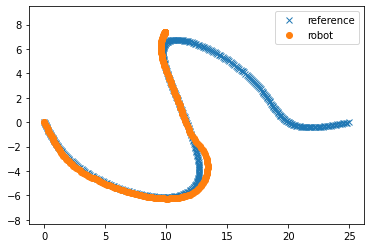

In [18]:
plt.plot(cx, cy, 'x', label="reference")
plt.plot(x, y, 'o', label="robot")
plt.axis("equal")
plt.legend()
plt.show()

# Look-Ahead PI-Controller

In [15]:
from mantrap.agents import DoubleIntegratorDTAgent, IntegratorDTAgent
from mantrap.controller import pi_controller

agent = DoubleIntegratorDTAgent(position=cxy_spline[0, :], velocity=torch.ones(2) * 1.0, is_robot=True)
controls = pi_controller(agent, path=cxy_spline, max_sim_time=MAX_TIME, dtc=DT, speed_reference = 1.0)

In [16]:
%%timeit
controls = pi_controller(agent, path=cxy_spline, max_sim_time=MAX_TIME, dtc=DT, speed_reference = 0.5)

167 ms ± 16.7 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


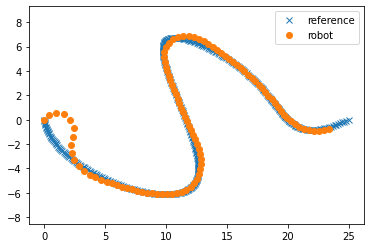

In [17]:
cxy_spline_np = cxy_spline.detach().numpy()
trajectory_np = agent.unroll_trajectory(controls, dt=DT).detach().numpy()

plt.plot(cxy_spline_np[:, 0], cxy_spline_np[:, 1], 'x', label="reference")
plt.plot(trajectory_np[:, 0], trajectory_np[:, 1], 'o', label="robot")
plt.axis("equal")
plt.legend()
plt.show()